In [1]:
import numpy as np
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt
plt.style.use('../l3.mplstyle')
cmap = matplotlib.colormaps.get_cmap('tab10').colors
from scipy.optimize import curve_fit
from jacobi import propagate
import os

In [2]:
conv = lambda s: float(s.decode().replace(',','.'))
dir = 'D:/Compton/'
def calibrate(x):
    return 372.69*x-37.90
def gauss(x, a, mu, s):
    return a*np.exp(-(x-mu)**2/(2*s**2))
def exponential(x, a, mu):
    return a*np.exp(-mu*x)

['2.12e+04 +- 7.98e+01', '6.62e+02 +- 9.11e-02', '2.84e+01 +- 8.36e-02']


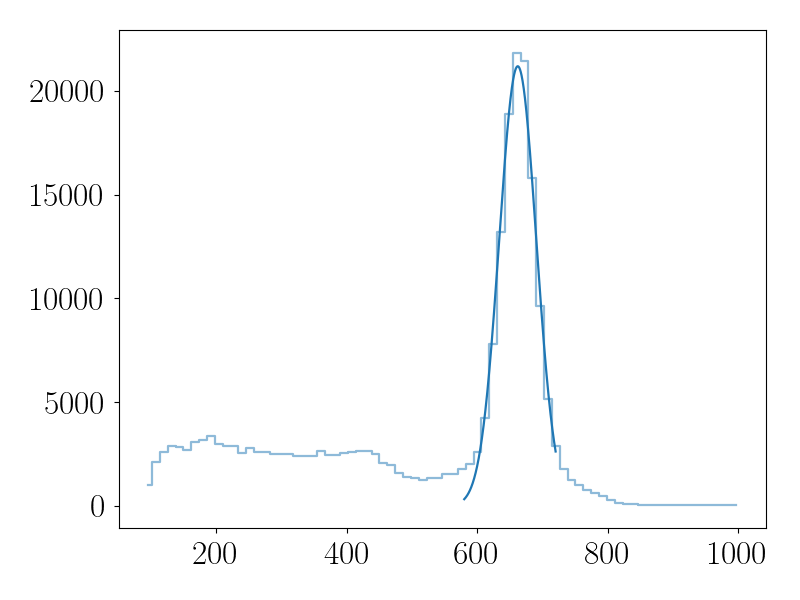

In [16]:
data = np.loadtxt(dir+'1_Cs', delimiter='\t', converters=conv)
fig,ax = plt.subplots()
c,b = np.histogram(data, bins=300)
b = calibrate(b[:-1])
c,b = c[b<1000], b[b<1000] # Throw away long unnesaary tail
mask = (b>580) & (b<720)
xplot = np.linspace(580,720,1000)
popt, pcov = curve_fit(gauss, b[mask], c[mask], p0=[5000, 640, 30], sigma= np.sqrt(c[mask]), absolute_sigma=True)
ax.step(b, c, where='mid',  alpha=0.5, color=cmap[0])
ax.plot(xplot, gauss(xplot, *popt), color=cmap[0])
integral_at_0 = np.sqrt(2*np.pi)*popt[0]*popt[2]
err_integral_at_0 = np.sqrt(2*np.pi)*np.sqrt(pcov[0,0]*popt[2]**2 + pcov[2,2]*popt[0]**2)
printer(popt, pcov)

In [15]:
def printer(popt, pcov):
    print([f'{popt[i]:.2e} +- {np.sqrt(pcov[i,i]):.2e}' for i in range(len(popt))])

['1.26e+04 +- 4.87e+01', '1.11e-01 +- 2.43e-03']
absorption coefficient: 0.11145801409834244 ± 0.0024308252712779833


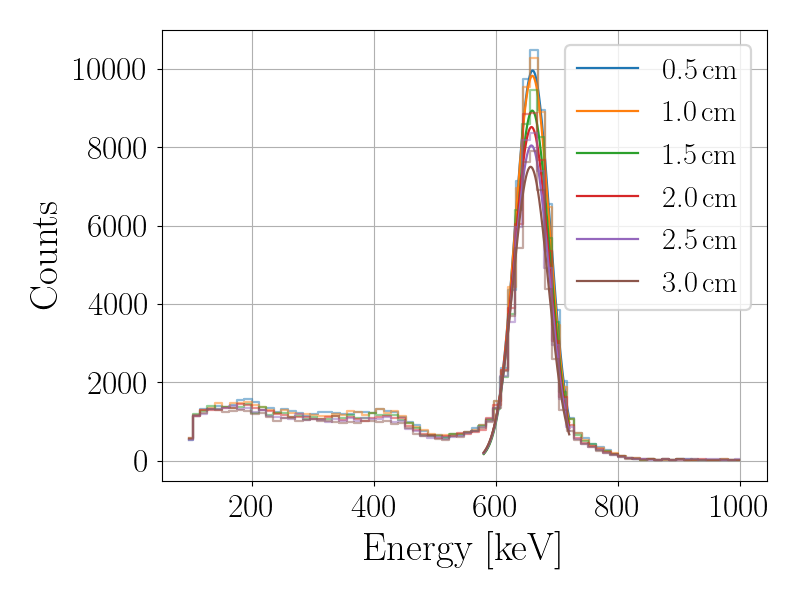

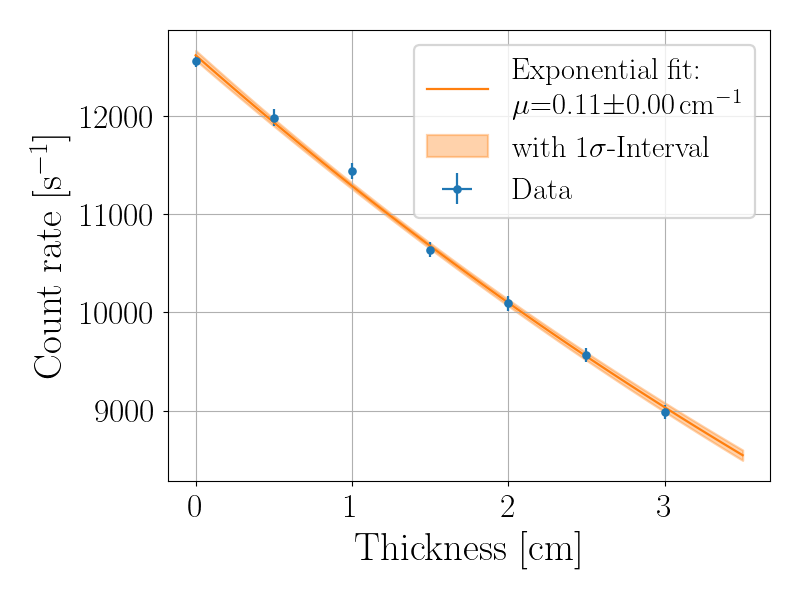

In [20]:
fnames = ['D:/Compton/2_Al_5', 'D:/Compton/2_Al_10', 'D:/Compton/2_Al_15', 'D:/Compton/2_Al_20', 'D:/Compton/2_Al_25', 'D:/Compton/2_Al_30']
meas_time = np.array([119979,59164,60503,59438,60494,60221,60195])*1e-3
thickness = np.array([0, 5,10,15,20,25,30])*0.1 # cm
integrals = [integral_at_0]
err_integrals = [err_integral_at_0]
fig,ax = plt.subplots()

for i,fname in enumerate(fnames):
    data = np.loadtxt(fname, delimiter='\t', converters=conv)
    c,b = np.histogram(data, bins=300)
    b = calibrate(b[:-1])
    c,b = c[b<1000], b[b<1000] # Throw away long unnesaary tail
    mask = (b>580) & (b<720)
    xplot = np.linspace(580,720,1000)
    popt, pcov = curve_fit(gauss, b[mask], c[mask], p0=[5000, 640, 30], sigma= np.sqrt(c[mask]), absolute_sigma=True)
    ax.step(b, c, where='mid', alpha=0.5, color=cmap[i])
    ax.plot(xplot, gauss(xplot, *popt), color=cmap[i], label=f'{thickness[i+1]:.1f}$\,$cm')
    integrals.append(np.sqrt(2*np.pi)*popt[0]*popt[2])  
    err_integrals.append(np.sqrt(2*np.pi)*np.sqrt(pcov[0,0]*popt[2]**2 + pcov[2,2]*popt[0]**2))
integrals, err_integrals = np.array(integrals), np.array(err_integrals)
ax.legend()
ax.set(xlabel='Energy [keV]', ylabel='Counts')
ax.grid()
fig.tight_layout()
fig.savefig('plots/mu_al_counts.pdf', bbox_inches='tight')
fig,ax= plt.subplots()
popt, pcov = curve_fit(exponential, thickness, integrals/meas_time, p0=[1, 0.1], sigma=err_integrals/meas_time, absolute_sigma=True)
printer(popt, pcov)
x_plot=np.linspace(0,3.5,100)
ax.errorbar(thickness, integrals/meas_time, yerr=err_integrals/meas_time, xerr=thickness*5e-5 , fmt='o', label='Data')
y, ycov = propagate(lambda fit_vec: exponential(x_plot, *fit_vec), popt, pcov)
ycov = np.sqrt(np.diag(ycov))
ax.plot(x_plot, exponential(np.linspace(0,3.5,100), *popt), label='Exponential fit:\n$\mu$={:.2f}$\pm${:.2f}$\,\mathrm{{cm}}^{{-1}}$'.format(popt[1], np.sqrt(pcov[1,1])), color=cmap[1])
ax.fill_between(x_plot, y-ycov, y+ycov, alpha=0.35, color=cmap[1], label='with 1$\sigma$-Interval')
ax.set(xlabel='Thickness [cm]', ylabel='Count rate [$\mathrm{s^{-1}}$]')
ax.grid()
ax.legend()
fig.tight_layout()
fig.savefig('plots/mu_al_fit.pdf', bbox_inches='tight')
print('absorption coefficient:', popt[1], '±', np.sqrt(pcov[1,1]))
mu_al = popt[1], np.sqrt(pcov[1,1])

## Lead

C:\Users\steph\AppData\Local\Temp\ipykernel_17212\1303049267.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


['9.85e+03 +- 5.37e+01', '6.58e+02 +- 1.26e-01', '2.85e+01 +- 1.11e-01']
['9.54e+03 +- 5.31e+01', '6.58e+02 +- 1.28e-01', '2.84e+01 +- 1.15e-01']
['8.77e+03 +- 5.13e+01', '6.57e+02 +- 1.34e-01', '2.81e+01 +- 1.21e-01']
['7.80e+03 +- 4.81e+01', '6.56e+02 +- 1.42e-01', '2.81e+01 +- 1.27e-01']
['6.89e+03 +- 4.53e+01', '6.55e+02 +- 1.52e-01', '2.83e+01 +- 1.39e-01']
['6.63e+03 +- 4.43e+01', '6.55e+02 +- 1.55e-01', '2.84e+01 +- 1.41e-01']
['5.91e+03 +- 4.18e+01', '6.55e+02 +- 1.66e-01', '2.86e+01 +- 1.51e-01']
['1.28e+04 +- 4.75e+01', '6.77e-01 +- 8.53e-03']
absorption coefficient: 0.6765221493033876 ± 0.00853105327923614


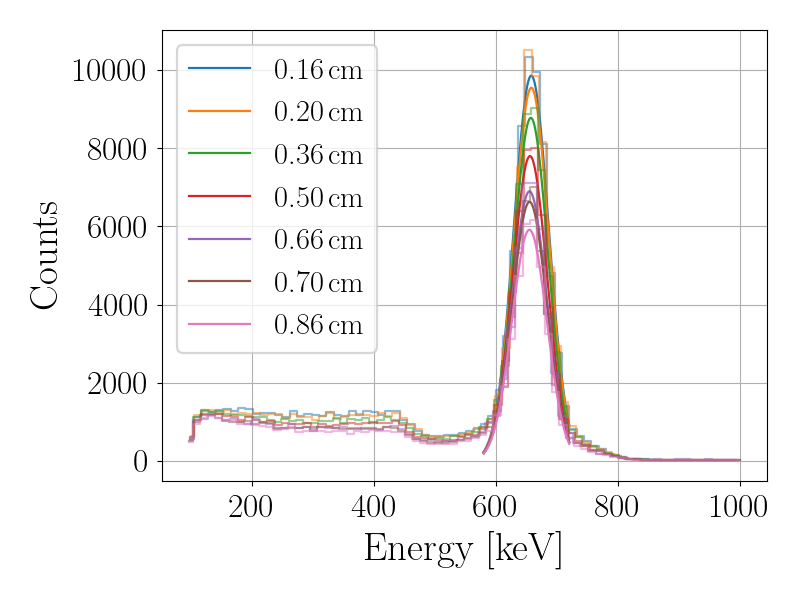

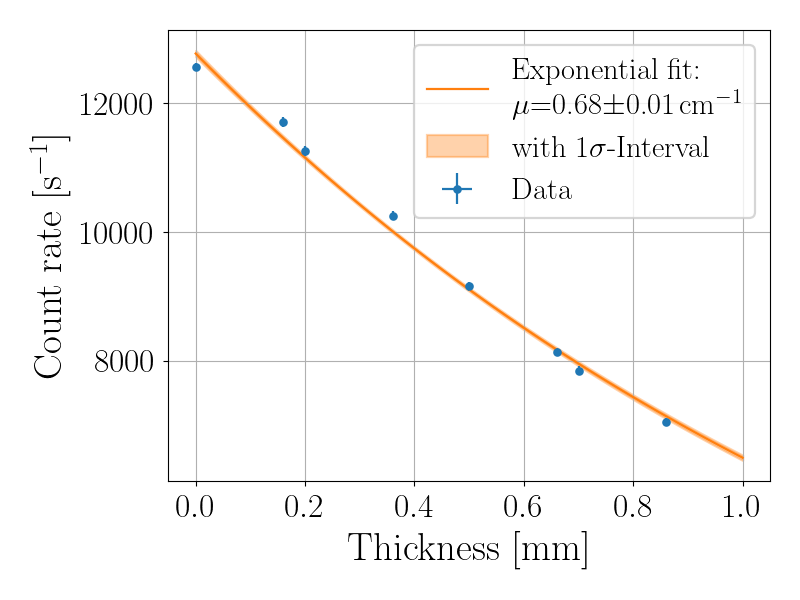

In [21]:
fnames = ['D:/Compton/2_Pb_1,6', 'D:/Compton/2_Pb_2', 'D:/Compton/2_Pb_3,6', 'D:/Compton/2_Pb_5', 'D:/Compton/2_Pb_6,6', 'D:/Compton/2_Pb_7', 'D:/Compton/2_Pb_8,6']
meas_time = np.array([119979,60174,60362,60148,60004,60111,60042,60044])*1e-3
thickness = np.array([0, 1.6, 2, 3.6, 5, 6.6, 7, 8.6])*0.1 #cm
integrals = [integral_at_0]
err_integrals = [err_integral_at_0]
fig,ax = plt.subplots()
for i,fname in enumerate(fnames):
    data = np.loadtxt(fname, delimiter='\t', converters=conv)
    c,b = np.histogram(data, bins=300)
    b = calibrate(b[:-1])
    c,b = c[b<1000], b[b<1000] # Throw away long unnesaary tail
    mask = (b>580) & (b<720)
    xplot = np.linspace(580,720,1000)
    popt, pcov = curve_fit(gauss, b[mask], c[mask], p0=[5000, 640, 30], sigma= np.sqrt(c[mask]), absolute_sigma=True)
    printer(popt, pcov)
    ax.step(b, c, where='mid', alpha=0.5, color=cmap[i])
    ax.plot(xplot, gauss(xplot, *popt), color=cmap[i], label= f'{thickness[i+1]:.2f}$\,$cm')
    integrals.append(np.sqrt(2*np.pi)*popt[0]*popt[2])  
    err_integrals.append(np.sqrt(2*np.pi)*np.sqrt(pcov[0,0]*popt[2]**2 + pcov[2,2]*popt[0]**2))
integrals, err_integrals = np.array(integrals), np.array(err_integrals)
ax.legend()
ax.set(xlabel='Energy [keV]', ylabel='Counts')
ax.grid()
fig.tight_layout()
fig.savefig('plots/mu_pb_counts.pdf', bbox_inches='tight')
fig,ax= plt.subplots()
ax.errorbar(thickness, integrals/meas_time, yerr=err_integrals/meas_time, xerr=thickness*0.001, label='Data', fmt='o')
popt, pcov = curve_fit(exponential, thickness, integrals/meas_time, p0=[1, 1.2], sigma=err_integrals/meas_time, absolute_sigma=True)
printer(popt,pcov)
x_plot= np.linspace(0,1.0,100)
y, ycov = propagate(lambda fit_vec: exponential(x_plot, *fit_vec), popt, pcov)
ycov = np.sqrt(np.diag(ycov))
ax.plot(x_plot, exponential(np.linspace(0,1.0,100), *popt), label='Exponential fit:\n$\mu$={:.2f}$\pm${:.2f}$\,\mathrm{{cm^{{-1}}}}$'.format(popt[1], np.sqrt(pcov[1,1])), color=cmap[1])
ax.fill_between(x_plot, y-ycov, y+ycov, alpha=0.35, color=cmap[1], label='with 1$\sigma$-Interval')
ax.set(xlabel='Thickness [mm]', ylabel='Count rate $\mathrm{[s^{-1}]}$')
ax.grid()
ax.legend()
fig.tight_layout()
fig.savefig('plots/mu_pb_fit.pdf', bbox_inches='tight')
print('absorption coefficient:', popt[1], '±', np.sqrt(pcov[1,1]))
mu_pb = popt[1], np.sqrt(pcov[1,1])

## Copper

['1.03e+04 +- 5.56e+01', '6.59e+02 +- 1.24e-01', '2.81e+01 +- 1.12e-01']
['9.32e+03 +- 5.25e+01', '6.58e+02 +- 1.31e-01', '2.83e+01 +- 1.18e-01']
['8.68e+03 +- 5.09e+01', '6.58e+02 +- 1.37e-01', '2.85e+01 +- 1.26e-01']
['8.06e+03 +- 4.89e+01', '6.57e+02 +- 1.41e-01', '2.83e+01 +- 1.28e-01']
['7.45e+03 +- 4.70e+01', '6.56e+02 +- 1.48e-01', '2.86e+01 +- 1.37e-01']
['6.71e+03 +- 4.45e+01', '6.56e+02 +- 1.57e-01', '2.90e+01 +- 1.46e-01']
['6.21e+03 +- 4.20e+01', '6.55e+02 +- 1.59e-01', '2.92e+01 +- 1.41e-01']
['1.27e+04 +- 4.71e+01', '3.64e-01 +- 5.15e-03']
absorption coefficient: 0.3640513221888868 ± 0.005148788713293448


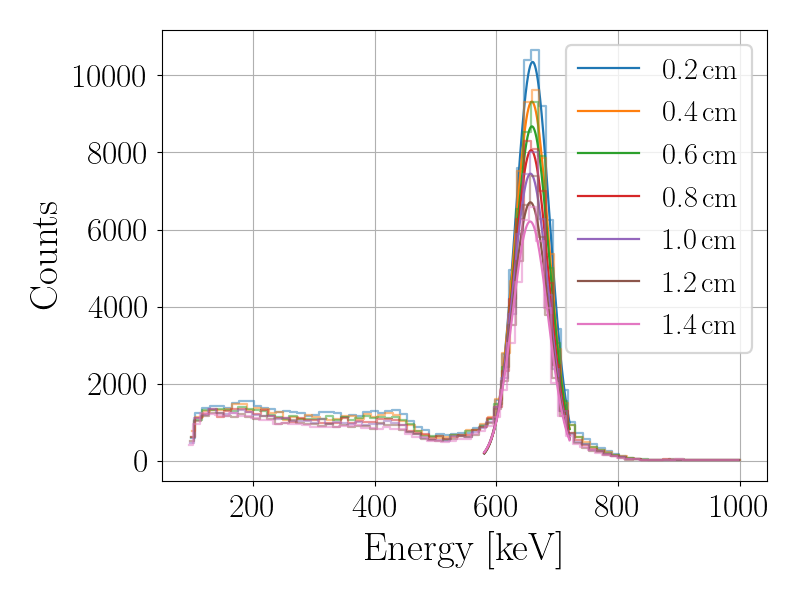

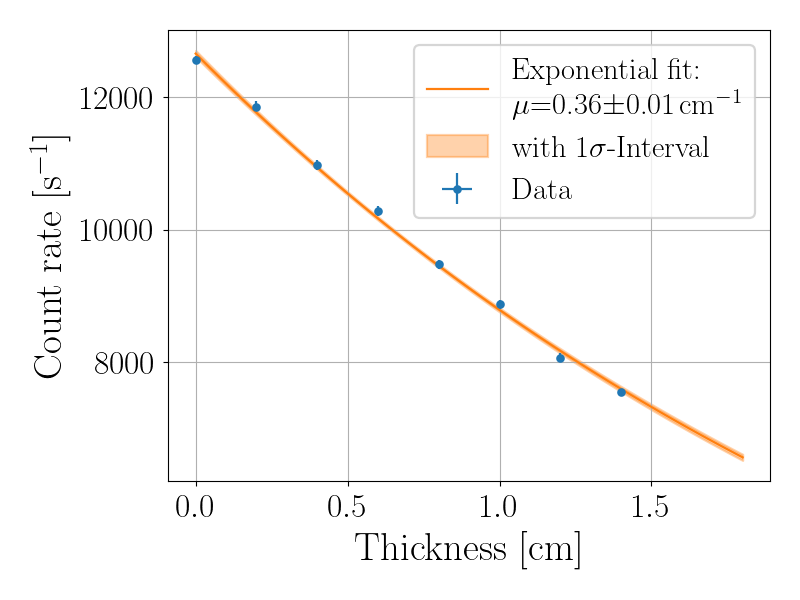

In [22]:
fnames = ['D:/Compton/2_Cu_2', 'D:/Compton/2_Cu_4', 'D:/Compton/2_Cu_6', 'D:/Compton/2_Cu_8', 'D:/Compton/2_Cu_10', 'D:/Compton/2_Cu_12', 'D:/Compton/2_Cu_14']
meas_time = np.array([119979, 61381,60140,60265,60297,60236,60284,60256])*1e-3
thickness = np.array([0,2,4,6,8,10,12,14])*0.1 # cm
integrals = [integral_at_0]
err_integrals = [err_integral_at_0]
fig,ax = plt.subplots()
for i,fname in enumerate(fnames):
    data = np.loadtxt(fname, delimiter='\t', converters=conv)
    c,b = np.histogram(data, bins=300)
    b = calibrate(b[:-1])
    c,b = c[b<1000], b[b<1000] # Throw away long unnesaary tail
    mask = (b>580) & (b<720)
    xplot = np.linspace(580,720,1000)
    popt, pcov = curve_fit(gauss, b[mask], c[mask], p0=[5000, 640, 30], sigma= np.sqrt(c[mask]), absolute_sigma=True)
    printer(popt, pcov)
    ax.step(b, c, where='mid', alpha=0.5, color=cmap[i])
    ax.plot(xplot, gauss(xplot, *popt), color=cmap[i], label= f'{thickness[i+1]:.1f}$\,$cm')
    integrals.append(np.sqrt(2*np.pi)*popt[0]*popt[2])  
    err_integrals.append(np.sqrt(2*np.pi)*np.sqrt(pcov[0,0]*popt[2]**2 + pcov[2,2]*popt[0]**2))
integrals, err_integrals = np.array(integrals), np.array(err_integrals)
ax.legend()
ax.set(xlabel='Energy [keV]', ylabel='Counts')
ax.grid()
fig.tight_layout()
fig.savefig('plots/mu_cu_counts.pdf', bbox_inches='tight')
fig,ax= plt.subplots()
ax.errorbar(thickness, integrals/meas_time, yerr=err_integrals/meas_time, xerr=thickness*3e-3, fmt='o', label='Data')
popt, pcov = curve_fit(exponential, thickness, integrals/meas_time, p0=[1, 0.1], sigma=err_integrals/meas_time, absolute_sigma=True)
printer(popt, pcov)
x_plot = np.linspace(0,1.8,100)
y, ycov = propagate(lambda fit_vec: exponential(x_plot, *fit_vec), popt, pcov)
ycov = np.sqrt(np.diag(ycov))
ax.plot(x_plot, exponential(np.linspace(0,1.8,100), *popt), label='Exponential fit:\n$\mu$={:.2f}$\pm${:.2f}$\,\mathrm{{cm^{{-1}}}}$'.format(popt[1], np.sqrt(pcov[1,1])), color=cmap[1])
ax.fill_between(x_plot, y-ycov, y+ycov, alpha=0.35, color=cmap[1], label='with 1$\sigma$-Interval')
ax.set(xlabel='Thickness [cm]', ylabel='Count rate $\mathrm{[s^{-1}]}$')
ax.grid()
ax.legend()
fig.tight_layout()
fig.savefig('plots/mu_cu_fit.pdf', bbox_inches='tight')
print('absorption coefficient:', popt[1], '±', np.sqrt(pcov[1,1]))
mu_cu = popt[1], np.sqrt(pcov[1,1])

In [7]:
e_radius = 2.8179403227e-15
h = 6.62607015e-34
e = 1.602176634e-19
nu = 0.662e6 * e / h
e_mass = 9.1093837139e-31
c = 299792458
g = h*nu/(e_mass*c**2)
N_a = 6.02214076e23
u = 1.66053906660e-27
###### Klein Nishina: #######
sigma = 2*np.pi*e_radius**2*((1+g)/g**2 * (2*(1+g)/(1+2*g)-np.log(1+2*g)/g) + 0.5/g * np.log(1+2*g) - (1+3*g)/(1+2*g)**2) # m^2
sigma = sigma * 1e4 # cm^2
def sigma_photo(mu,err_mu, A, Z_eff, rho):
    
    value = mu* A/(N_a*rho) - Z_eff * sigma
    error = A / (N_a*rho) *err_mu
    return value, error

cu = sigma_photo(mu_cu[0], mu_cu[1], 63.55, 29-2, 8.933) # https://pubchem.ncbi.nlm.nih.gov/periodic-table/
pb = sigma_photo(mu_pb[0], mu_pb[1], 207, 82-2, 11.342) 
al = sigma_photo(mu_al[0], mu_al[1], 26.981538, 13-2, 2.7)

print('We get for sigma_photo:\n\tCu:{}\n\tPb:{}\n\tAl:{}\nin units cm^2'.format(cu, pb, al))
print('MNIST values are:\n\tCu: {} cm^2\n\tPb: {} cm^2\n\tAl: {} cm^2'.format(1.274e-3 * 63.55 /N_a, 4.333e-2 * 207 /N_a, 6.558e-5 * 26.981538 /N_a))  

We get for sigma_photo:
	Cu:(-2.6151807993247934e-24, 6.082363746645815e-26)
	Pb:(1.150781489247671e-26, 2.5854280388316217e-25)
	Al:(-9.680055493720536e-25, 4.0337202728815374e-26)
in units cm^2
MNIST values are:
	Cu: 1.3444172633387598e-25 cm^2
	Pb: 1.4893889660593056e-23 cm^2
	Al: 2.9382396269993534e-27 cm^2


## 6

['5.17e+01 +- 2.73e+00', '6.62e+02 +- 1.32e+00', '3.22e+01 +- 1.08e+00']
['3.85e+01 +- 2.52e+00', '6.04e+02 +- 1.90e+00', '3.65e+01 +- 1.50e+00']
['9.26e+01 +- 3.87e+00', '5.61e+02 +- 1.24e+00', '3.76e+01 +- 9.92e-01']
['1.41e+02 +- 4.88e+00', '5.18e+02 +- 9.80e-01', '3.63e+01 +- 7.95e-01']
['1.38e+02 +- 4.71e+00', '4.62e+02 +- 1.01e+00', '3.74e+01 +- 7.96e-01']
['1.32e+02 +- 5.02e+00', '4.13e+02 +- 9.57e-01', '3.23e+01 +- 7.80e-01']
['1.32e+02 +- 5.53e+00', '3.69e+02 +- 8.63e-01', '2.66e+01 +- 7.07e-01']
['1.08e+02 +- 5.22e+00', '3.31e+02 +- 9.40e-01', '2.51e+01 +- 7.85e-01']
['1.15e+02 +- 5.68e+00', '2.96e+02 +- 8.48e-01', '2.21e+01 +- 6.92e-01']
['8.69e+01 +- 5.08e+00', '2.68e+02 +- 9.75e-01', '2.17e+01 +- 8.42e-01']


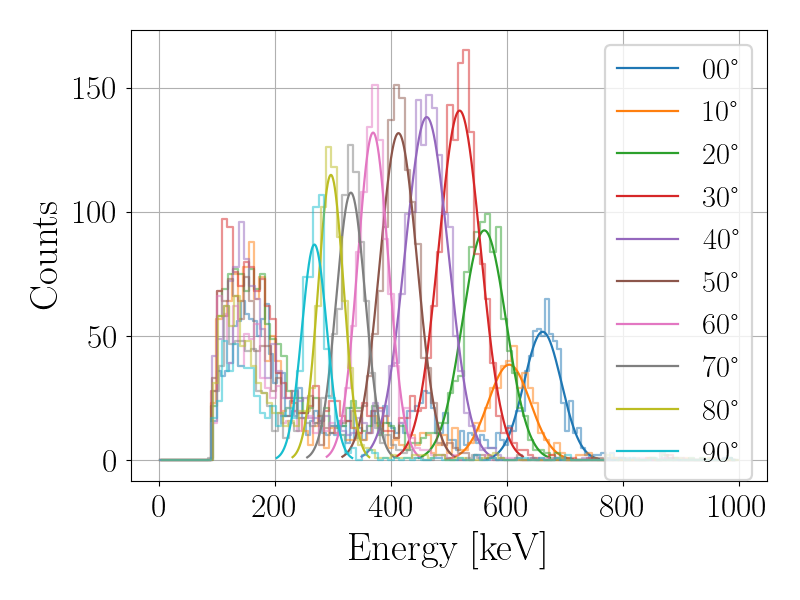

In [23]:
mu_guess = np.linspace(660, 220, 10)
fig,ax = plt.subplots()
energies = []
integrals = []
for i in range(10):
    if i == 0:
        data = np.loadtxt(dir+'3_0', delimiter='\t', converters=conv)
    else: 
        data = np.loadtxt(dir+f'3_{i}0', delimiter='\t', converters=conv)
    c,b = np.histogram(data, bins=400)
    b = calibrate(b[:-1])
    c,b = c[(b>0) & (b<1000)], b[(b>0) & (b<1000)] # Throw away uninteresting regions
    fit_window = (b>200) 
    sigma = np.sqrt(c[fit_window])
    sigma[sigma==0] = 1
    popt, pcov = curve_fit(gauss, b[fit_window], c[fit_window], p0=[60, mu_guess[i], 30], sigma=sigma, absolute_sigma=True)
    printer(popt, pcov)
    x_plot = np.linspace(popt[1]-3*popt[2], popt[1]+3*popt[2], 1000)
    energies.append((popt[1], popt[2]))
    integrals.append((np.sqrt(2*np.pi)*popt[0]*popt[2], np.sqrt(2*np.pi)*np.sqrt(pcov[0,0]*popt[2]**2 + pcov[2,2]*popt[0]**2)))
    ax.step(b, c, where='mid', alpha=0.5, color=cmap[i])
    ax.plot(x_plot, gauss(x_plot, *popt), label=f'{i}0°', color=cmap[i])
ax.legend()
ax.set(xlabel='Energy [keV]', ylabel='Counts')
ax.grid()
fig.tight_layout()
fig.savefig('plots/angle_dependent_count_hists.pdf', bbox_inches='tight')

['2.93e-12 +- 1.89e-13']
Compton wavelength: 2.9282060550747198 ± 0.18888186766614584 pm
Which leads to an electorn mass of: 7.55e-31 +- 4.87e-32kg


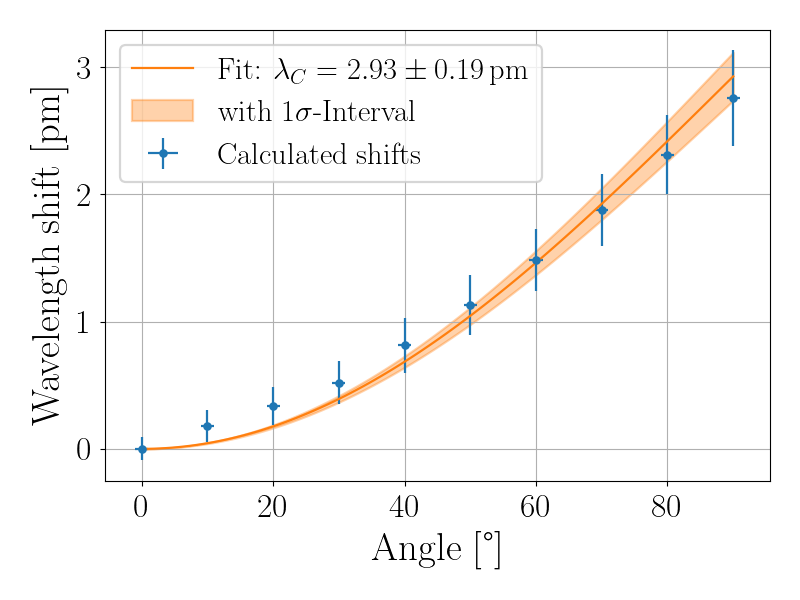

In [24]:
h = 6.62607015e-34
e = 1.602176634e-19
c = 299792458

energies, integrals = np.array(energies), np.array(integrals)
lambda_incident = h*c/(0.662e6 * e)
angles = np.linspace(0,90,10)*np.pi/180
wavelenght_shifts = h*c/(energies[:,0]*1e3 * e) - lambda_incident
err_wavelenght_shifts = energies[:,1]*1e3* h*c/((energies[:,0]*1e3)**2 * e)
def compton(theta, wavelength):
    return wavelength*(1 - np.cos(theta))
popt, pcov = curve_fit(compton, angles, wavelenght_shifts, p0=[1e-12], sigma=err_wavelenght_shifts, absolute_sigma=True)
printer(popt, pcov)
x_plot = np.linspace(0, 0.5*np.pi, 100)
y, ycov = propagate(lambda fit_vec: compton(x_plot, *fit_vec), popt, pcov)
ycov = np.sqrt(np.diag(ycov))

fig,ax = plt.subplots()
ax.errorbar(angles*180/np.pi, wavelenght_shifts*1e12, err_wavelenght_shifts*1e12, 1, 'o', label='Calculated shifts')
ax.plot(np.linspace(0,90,100), compton(np.linspace(0,90,100)*np.pi/180, *popt)*1e12, label='Fit: $\lambda_C = {:.2f} \pm {:.2f}\,$pm'.format(popt[0]*1e12, pcov[0,0]**0.5*1e12), color=cmap[1])
ax.fill_between(x_plot*180/np.pi, (y-ycov)*1e12, (y+ycov)*1e12, alpha=0.35, color=cmap[1], label='with 1$\sigma$-Interval')
ax.set(xlabel='Angle [°]', ylabel='Wavelength shift [pm]')
ax.grid()
ax.legend()
fig.tight_layout()
fig.savefig('plots/compton_wavelenght.pdf', bbox_inches='tight')
print('Compton wavelength:', popt[0]*1e12, '±', pcov[0,0]**0.5*1e12, 'pm')
print('Which leads to an electorn mass of: {:.2e} +- {:.2e}kg'.format(h/(popt[0]*c), h/(popt[0]**2*c)*pcov[0,0]**0.5))  

## Get energies at which i want to know the det. efficincy

In [10]:
def compto_energy(theta):
    theta = theta*np.pi/180
    value = 0.662*1e6 / (1+ 0.662*1e6/(511e3)*(1-np.cos(theta)))
    error = (0.662e6)**2*np.sin(theta)* 1*np.pi/180 /(511e3*(1+0.662e6/(511e3)*(1-np.cos(theta)))**2)
    return value, error

energies = []
err_energies = []
ilist = []
for i in range(0, 100, 10):
    energy, err_energy = compto_energy(i)
    energies.append(energy)
    err_energies.append(err_energy)
    ilist.append(i)

arr = np.vstack((ilist, energies, err_energies)).T
np.savetxt('compton_energies.txt', arr, header='Angle [deg], Energy [eV], Error [eV]')

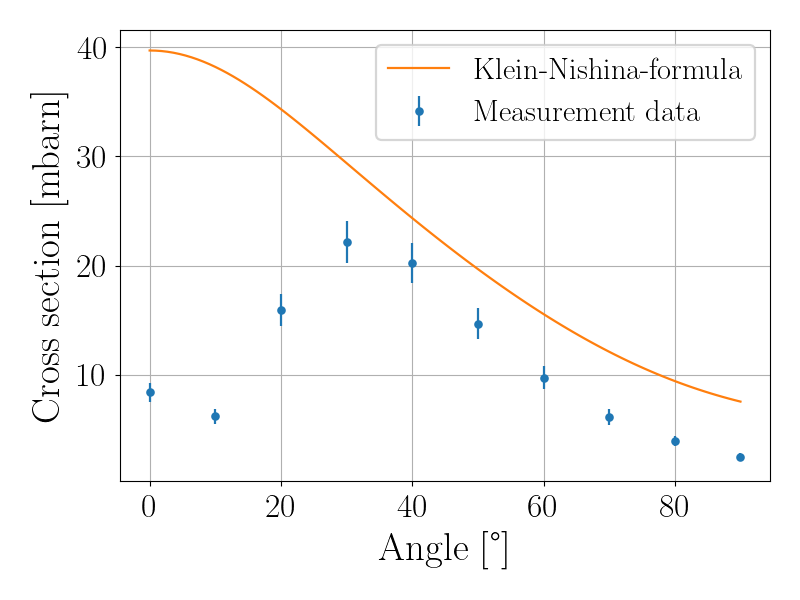

In [11]:
I = integrals[:,0]
err_I = integrals[:,1]
time = np.array([538297,606685,561684,552765,546871,529688,536988,513796,578972,516032])*1e-3
rates = I/time
err_rates = err_I/time
data = np.loadtxt('compton_energies_fit.txt')
det_eff = data[:,1]
err_det_eff = data[:,2]
def compton_cs(R, sigma_R, det_eff, sigma_det_eff):
    # everythin in g and cm
    constant = (4*1/0.54) / (36.69e6*0.851*0.475**2*N_a*1.032)
    value = constant * R*32.5**2 / det_eff
    error = np.sqrt((constant*32.5**2/det_eff * sigma_R)**2 + (constant*2*32.5*R/det_eff * 1)**2 + (constant*R*32.5**2/det_eff**2 * sigma_det_eff)**2)
    return value, error
def th_compton_cs(theta):
    g = 0.662e6 * e/(e_mass*c**2)
    return e_radius**2/2 *(1+g*(1-np.cos(theta)))**(-2) * (1+ np.cos(theta)**2 * (g**2 * (1-np.cos(theta))**2) / (1+g*(1-np.cos(theta))))
value, error = compton_cs(rates, err_rates, det_eff, err_det_eff)
fig,ax = plt.subplots()
ax.errorbar(ilist, value*1e27, yerr=error*1e27, fmt='o', label='Measurement data')
ax.plot(np.linspace(0,90,100), th_compton_cs(np.linspace(0,90,100)*np.pi/180)*1e4*1e27, label='Klein-Nishina-formula')
ax.set(xlabel='Angle [°]', ylabel='Cross section [mbarn]')
ax.legend()
ax.grid()
fig.tight_layout()
fig.savefig('plots/diff_compton_cross_section.pdf', bbox_inches='tight')